### Package Import

In [1]:
import h5py
import os
import cv2  
import pandas as pd
import matplotlib.pyplot as plt             
import numpy as np                        
import tensorflow as tf                
from tqdm import tqdm
from collections import Counter


### GPU Testing

In [5]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [6]:
'''Release Memory'''
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))
reset_keras()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

186
Physical devices cannot be modified after being initialized


### Data Preprocessing

In [7]:
# '''Use best model to predict unlabeled data''' 
# import os
# import cv2
# import numpy as np
# import pandas as pd
# from tqdm import tqdm
# from tensorflow import keras
# from keras.applications.efficientnet_v2 import preprocess_input

# model = keras.models.load_model('./TrainingRecord/EfficientNetV2B2/2/2.h5')
# size_0 = 288
# size_1 = 288
# target_size = (size_0, size_1)
# directoryName = "./Materials/dataset/unlabeled_data"
# result_path = []  
# result = [] 

# for filename in tqdm(os.listdir(directoryName), position=0):
#     img = cv2.imread(os.path.join(directoryName, filename))
#     if img is None:
#         continue
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, target_size) 
#     img = np.expand_dims(img, axis=0)
#     img = preprocess_input(img)
#     predictions = model.predict(img,verbose=0)
#     predicted_class = np.argmax(predictions)
#     confidence = predictions[0, predicted_class]    
#     if confidence > 0.9:
#         result_path.append(filename)
#         result.append(predicted_class)
#     else:
#         continue
        
# unlabeled_img_result_df = pd.DataFrame({'Name': result_path, 'Type': result})
# unlabeled_img_result_df.to_csv('./unlabeled_img_result.csv', index=False)


Original Training Data Distribution: 
Class 0 : 674, 26.66%
Class 1 : 492, 19.46%
Class 5 : 644, 25.47%
Class 3 : 378, 14.95%
Class 4 : 240, 9.49%
Class 2 : 100, 3.96%
total count:  2528
------------------------------------------
------------------------------------------


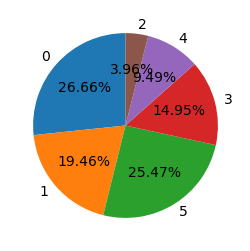

In [8]:
'''Check the distribution of the data'''

print('Original Training Data Distribution: ')
trainingData = pd.read_csv('train.csv')
trainingData_dict = trainingData.to_dict('list')
trainingData_dict = dict(zip(trainingData_dict['ID'], trainingData_dict['Label']))
class_counts = Counter(trainingData_dict.values())
for class_name, class_count in class_counts.items():
    class_percentage = class_count / len(trainingData_dict) * 100
    print(f"Class {class_name} : {class_count}, {class_percentage:.2f}%")
print("total count: ", len(trainingData_dict))

print('------------------------------------------')

# print('Unlabel Data Distribution: ')
# unlabelData = pd.read_csv('./Materials/dataset/unlabeled_img_result.csv')
# unlabelData_dict = unlabelData.to_dict('list')
# unlabelData_dict = dict(zip(unlabelData_dict['Name'], unlabelData_dict['Type']))
# class_counts = Counter(unlabelData_dict.values())
# for class_name, class_count in class_counts.items():
#     class_percentage = class_count / len(unlabelData_dict) * 100
#     print(f"Class {class_name} : {class_count}, {class_percentage:.2f}%")
# print("total count: ", len(unlabelData_dict))

print('------------------------------------------')

# print('New Training Data Distribution: ')
# trainingData_dict.update(unlabelData_dict)
# class_counts = Counter(trainingData_dict.values())
# for class_name, class_count in class_counts.items():
#     class_percentage = class_count / len(trainingData_dict) * 100
#     print(f"Class {class_name} : {class_count}, {class_percentage:.2f}%")
# print("total count: ", len(trainingData_dict))

plt.figure(figsize=(3, 3))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.2f%%', startangle=90)
plt.show()

In [9]:
'''Data Loader'''
from keras.applications.efficientnet_v2 import preprocess_input
size_0 = 288
size_1 = 288
target_size = (size_0, size_1) 
def LoadData(directoryName):
    output = [] 
    for filename in tqdm(os.listdir(directoryName)):
        img = cv2.imread(os.path.join(directoryName, filename))
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size) 
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        img = np.squeeze(img, axis=0)  
        
        # if directoryName == "./Materials/dataset/unlabeled_data":
        #     if filename in trainingData_dict:
        #         label = trainingData_dict.get(filename)
        #         output.append((img, label))  
        #     else:
        #         continue  
            
        if directoryName == "test_images" or directoryName == "train_images":
            if filename in trainingData_dict:
                label = trainingData_dict.get(filename)
                output.append((img, label))
            else:
                output.append((img, None))
    return output

test_data = LoadData("test_images")
train_data = LoadData("train_images")
# unlabel_data = LoadData("./Materials/dataset/unlabeled_data")
# train_data = train_data + unlabel_data

100%|██████████| 2528/2528 [00:14<00:00, 170.18it/s]


In [10]:
'''Check the size of the data'''
test_images = np.array([img for img, label in test_data], dtype='float16')
# unlabel_images = np.array([img for img, label in unlabel_data], dtype='float16')
train_images, train_labels = zip(*train_data)
train_images = np.array(train_images, dtype = 'float16') 
train_labels = np.array(train_labels, dtype = 'int32')

print(f"Number of training examples: {train_images.shape[0]} images")
# print(f"Number of unlabel examples: {unlabel_images.shape[0]} images")
print(f"Number of testing examples: {test_images.shape[0]} images")
print ("Each image is size of: {}".format(target_size))

'''rescale the pixel values in the images to be between 0 and 1'''
# train_images = train_images / 255.0
# test_images = test_images / 255.0

'''normalize the pixel values in the images to have mean of 0 and standard deviation of 1'''
#mean = np.mean(train_images)
#std = np.std(train_images)
#train_images = (train_images - mean) / (std+1e-7)
#test_images = (test_images - mean) / (std+1e-7)

'''one hot encode the labels'''
from tensorflow.keras.utils import to_categorical
num_classes = len(np.unique(train_labels))
train_labels = to_categorical(train_labels, num_classes=num_classes)

Number of training examples: 2528 images
Number of testing examples: 10142 images
Each image is size of: (288, 288)


### Function Testing

In [9]:
# function_test_data = LoadData("./Materials/testing")
# function_test_data

# for i in range(0, len(function_test_data)):
#     plt.figure()
#     plt.imshow(function_test_data[i][0])
#     plt.grid(False)
#     plt.axis('off')

### Model Building

In [10]:
'''Data Augmentation'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    zoom_range = 0.2,
    brightness_range = [0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(train_images)

In [14]:
'''Model Building'''
from tensorflow.keras.applications import EfficientNetV2B1, InceptionResNetV2,EfficientNetV2B0,MobileNet,InceptionV3,ResNet50,VGG16,EfficientNetB3, EfficientNetB7, EfficientNetV2L ,EfficientNetV2M , EfficientNetV2S , EfficientNetV2B3, EfficientNetV2B2 ,Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=(size_0, size_1, 3))

# for layer in base_model.layers[:-78]:
#      layer.trainable = False
base_model.trainable = True    

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    # BatchNormalization(),
    Dense(368, activation='relu'),#, kernel_regularizer=l2(0.01)
    # Dropout(0.3),
    Dense(6, activation='softmax')  
])

# model = keras.models.load_model('./Models/test.h5')

optimizer = tf.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 9, 9, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 368)               518512    
                                                                 
 dense_1 (Dense)             (None, 6)                 2214      
                                                                 
Total params: 9,290,100
Trainable params: 9,207,812
Non-trainable params: 82,288
_________________________________________________________________


In [15]:
'''Model Training'''
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def lr_decay(epoch):
  start_lr = 0.0001
  drop = 0.5
  epochs_drop = 1
  lr = start_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lr
lr_scheduler = LearningRateScheduler(lr_decay)

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array(batch_x), np.array(batch_y)
    
reset_keras()

checkpint = ModelCheckpoint(filepath='v0.h5', monitor='val_accuracy', verbose=2, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)
datagen.fit(X_train)
train_gen = DataGenerator(X_train, y_train, 16)
test_gen = DataGenerator(X_val, y_val, 16)
history = model.fit(train_gen,validation_data=test_gen, epochs=10, callbacks=[checkpint,lr_scheduler,early_stopping])

pd.DataFrame(history.history).to_csv("v0.csv")

1308
Epoch 1/10
143/143 [==============================] - ETA: 0s - loss: 0.8295 - accuracy: 0.7516
Epoch 1: val_accuracy improved from -inf to 0.87747, saving model to v0.h5
143/143 [==============================] - 32s 152ms/step - loss: 0.8295 - accuracy: 0.7516 - val_loss: 0.3797 - val_accuracy: 0.8775 - lr: 5.0000e-05
Epoch 2/10
143/143 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.9218
Epoch 2: val_accuracy improved from 0.87747 to 0.92490, saving model to v0.h5
143/143 [==============================] - 33s 230ms/step - loss: 0.2736 - accuracy: 0.9218 - val_loss: 0.2690 - val_accuracy: 0.9249 - lr: 2.5000e-05
Epoch 3/10
143/143 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9508
Epoch 3: val_accuracy improved from 0.92490 to 0.93281, saving model to v0.h5
143/143 [==============================] - 32s 224ms/step - loss: 0.1736 - accuracy: 0.9508 - val_loss: 0.2370 - val_accuracy: 0.9328 - lr: 1.2500e-05
Epoch 4/10
143/143 [===

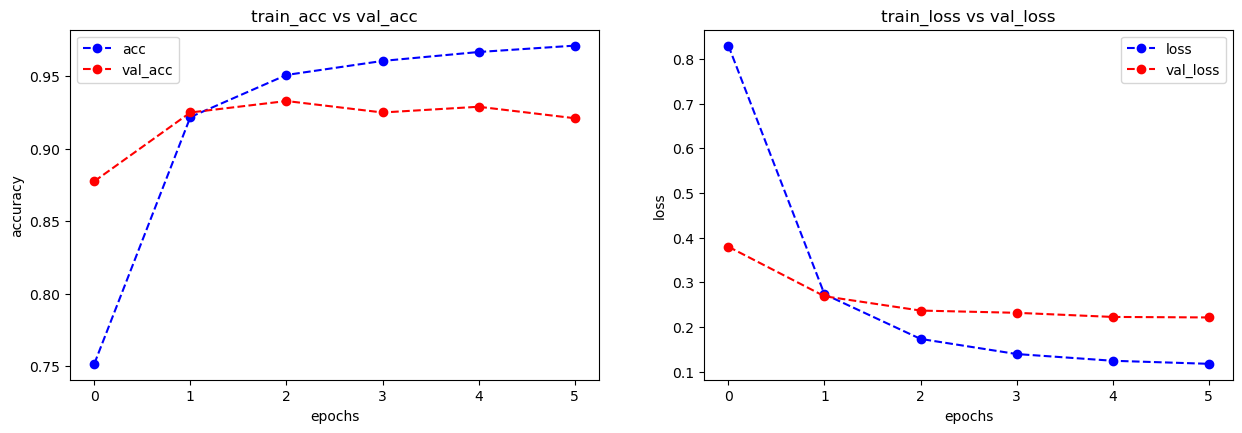

In [16]:
'''Model Evaluation'''
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
    
plot_accuracy_loss(history)

### Predictions

### Saliency Map

1/1 [==============================] - 5s 5s/step
Predicted Class: 1


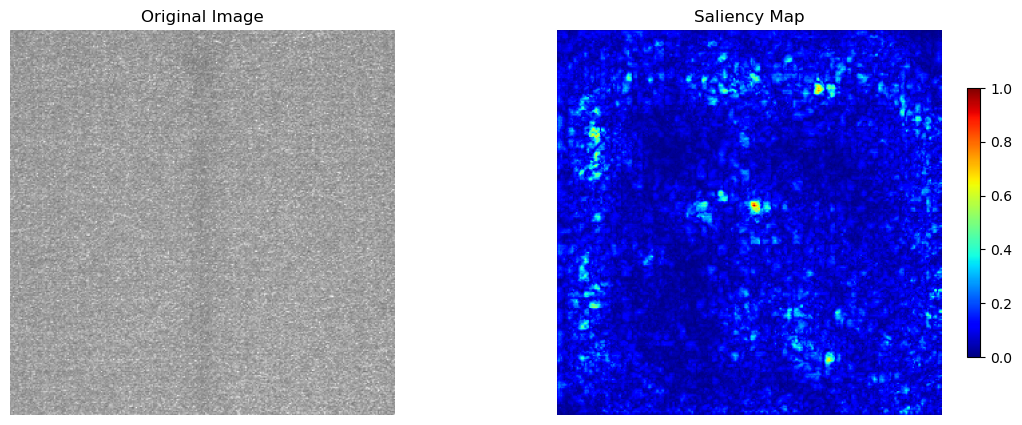

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# 設定圖片大小
size_0 = 288
size_1 = 288
target_size = (size_0, size_1) 

# 載入圖片並預處理
def load_and_preprocess_image(image_path, target_size):
    # 使用 OpenCV 讀取圖片
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 轉換到 RGB
    img = cv2.resize(img, target_size)         # 調整大小
    img = keras.applications.imagenet_utils.preprocess_input(img)  # 預處理 (e.g., 減去均值)
    img = np.expand_dims(img, axis=0)          # 添加 batch 維度
    return img

# 載入模型
model = keras.models.load_model('v0.h5')

# 預測類別
def predict_class(model, img):
    predictions = model.predict(img)
    pred_label = np.argmax(predictions, axis=1)[0]
    return pred_label, predictions

# 計算 Saliency Map
def compute_saliency_map(model, img, original_img):
    images = tf.Variable(img, dtype=float)  # 包裝圖片為 TensorFlow 變數
    with tf.GradientTape() as tape:
        pred = model(images, training=False)
        class_idx = np.argmax(pred.numpy())  # 取得預測類別索引
        loss = pred[0][class_idx]            # 計算對應類別的 loss
    
    grads = tape.gradient(loss, images)     # 計算梯度
    dgrad_abs = tf.math.abs(grads)          # 取絕對值
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]  # 取最大值作為可視化依據

    # 正規化到範圍 [0, 1]
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
    return grad_eval

# 顯示圖片和 Saliency Map
def display_results(original_img, saliency_map):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].imshow(original_img)  # 原始圖片
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    heatmap = axes[1].imshow(saliency_map, cmap="jet", alpha=1)  # Saliency Map
    axes[1].set_title("Saliency Map")
    axes[1].axis('off')

    fig.colorbar(heatmap, ax=axes[1], shrink=0.7)
    plt.show()

# 主程式
if __name__ == "__main__":
    image_path = 'test_images/test_01016.png'
    img = load_and_preprocess_image(image_path, target_size)  # 預處理後圖片
    _img = keras.preprocessing.image.load_img(image_path, target_size=target_size)  # 原始圖片

    # 預測類別
    pred_label, predictions = predict_class(model, img)
    print(f"Predicted Class: {pred_label}")
    # print(f"Predictions: {predictions}")

    # 計算 Saliency Map
    saliency_map = compute_saliency_map(model, img, _img)

    # 顯示結果
    display_results(_img, saliency_map)


1/1 [==============================] - 0s 24ms/step
Predicted Class: 1


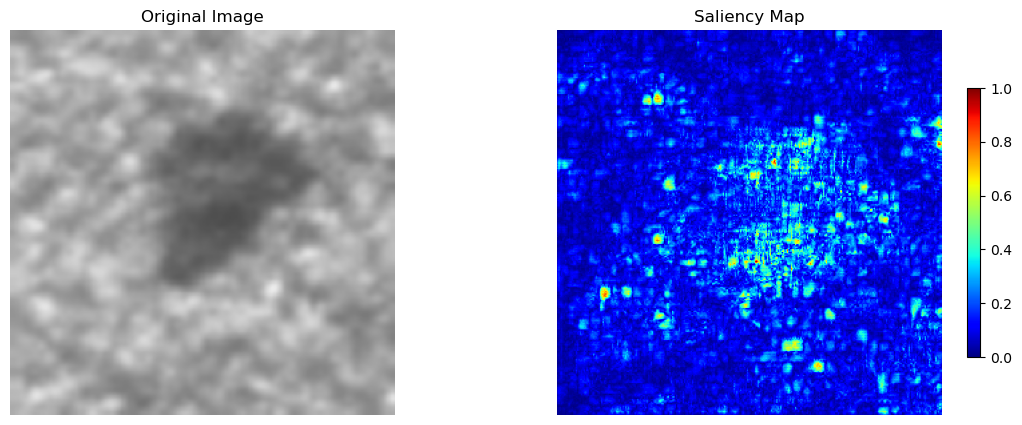

In [51]:
# 主程式
if __name__ == "__main__":
    image_path = 'test_images/test_00350.png'
    # image_path = 'train_images/train_00088.png'
    img = load_and_preprocess_image(image_path, target_size)  # 預處理後圖片
    _img = keras.preprocessing.image.load_img(image_path, target_size=target_size)  # 原始圖片

    # 預測類別
    pred_label, predictions = predict_class(model, img)
    print(f"Predicted Class: {pred_label}")
    # print(f"Predictions: {predictions}")

    # 計算 Saliency Map
    saliency_map = compute_saliency_map(model, img, _img)

    # 顯示結果
    display_results(_img, saliency_map)

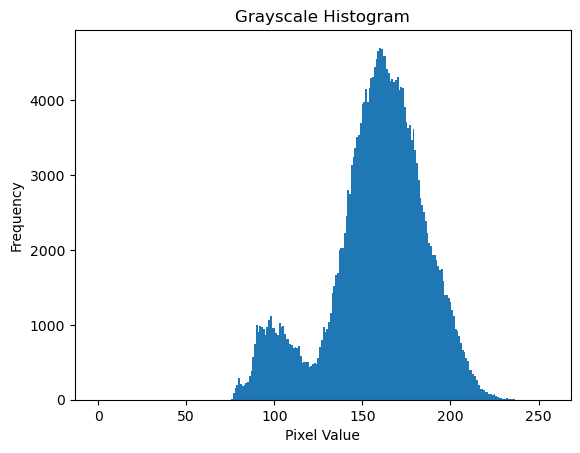

In [57]:
import cv2
import matplotlib.pyplot as plt

# 讀取灰階圖像
img = cv2.imread('test_images/test_00350.png', cv2.IMREAD_GRAYSCALE)

# 計算直方圖
hist = cv2.calcHist([img], [0], None, [256], [0, 256])

# 將直方圖數據壓平成一維陣列
hist = hist.ravel()

# 畫出直方圖
plt.bar(range(256), hist, width=1.0)  # 注意範圍和寬度的設置
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Grayscale Histogram')
plt.show()


### Save Predictions

In [18]:
# predData = pd.read_csv('./Materials/dataset/sample_submission.csv')
# predData['Type'] = pred_labels
# predData.to_csv('./Predictions/34.csv', index=False)